<a href="https://colab.research.google.com/github/ishriana/Assignments/blob/main/Oil_price_redo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pandas import Timestamp
from pandas_profiling import ProfileReport
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

**Inferences from Data**

1.Oil prices crossed 100 per barrel after 2008
2. To be precise Feb 2008 marks the onset of this spike 
3. this continued uptil july 2008.
4. 14th July 2008 marks the highest price for oil trade
5. 145.17 per barrel is what that sharp curve denotes in our line plot
6. Whereas the lowest values have been observed in 2020
7. Oil was traded at much lower prices than what it was 20 years back. Amazing isn't it...??? 
8. Lowest value was -37.6 and in the positive slab it was somewhere near 10
9. These max and min values seem like outliers 
10. But i would prefer to keep them in my model as i want my model to learn from highest and lowest prices



Reason why i have included the following columns in my dataset:

What Is West Texas Intermediate (WTI)?

West Texas Intermediate (WTI) crude oil is a specific grade of crude oil and one of the main three benchmarks in oil pricing, along with Brent and Dubai Crude. 

hence WTI price and Brent prices would be a part of our dataset

Historically, crude oil prices have seen increases in times when OPEC production targets are reduced. OPEC member countries produce about 40 percent of the world's crude oil. Equally important to global prices, OPEC's oil exports represent about 60 percent of the total petroleum traded internationally.


Hence i have decided to include Dubai oil price 

Gross domestic product (GDP) is an estimate of the total value of finished goods and services produced in a country’s borders during a specified period, usually a year.The share of US GDP to world Gdp is the largest ie: approx 16% and holding approx 25% of world economy

In our dataset we have real gdp and nominal gdp. latter is calculated as per base rate. Hence we can analyse the actual growth of the largest contributor from this measure.


## **DATA WRANGLING**

In [2]:
crude_df = pd.read_csv('/content/Crude_All.csv')
crude_df.isnull().sum()
crude_df.dropna(axis=0,how='any',inplace=True)

In [3]:
crude_df['Date'] = pd.to_datetime(crude_df['Date'])

In [4]:
crude_df = crude_df.set_index('Date')

Removing Unwanted Features

In [5]:
crude_df.drop(['Open','High','Low','Adj Close','Real Gdp'], axis=1, inplace=True)

In [6]:
crude_df.shape

(5133, 3)

Creating a monthly dataframe

In [7]:
monthly_df = crude_df.resample('M').agg({'Close':'mean','Volume':'sum','Nominal Gdp':'mean'})

Adding more features to monthly dataframe

In [8]:
finally_df = pd.read_csv('/content/Final.csv')
finally_df['Date'] = pd.to_datetime(finally_df['Date'])
finally_df = finally_df.set_index('Date')

In [9]:
finally_df.drop(finally_df.tail(4).index,axis=0,inplace=True)
finally_df.shape

(247, 11)

In [10]:
monthly_df['Brent'] = finally_df['Brent']
monthly_df['WTI'] = finally_df['WTISPLC']
monthly_df['Dubai'] = finally_df['Dubai']
monthly_df['US Inf'] = finally_df['US Inf']

In [11]:
monthly_df = monthly_df.reset_index()

Creating a column with names of the month

In [12]:
monthly_df['Month'] = monthly_df['Date'].dt.month_name()

In [13]:
monthly_df['year'] = monthly_df['Date'].dt.year

Next we will derive another 4 columns:

1. 90 days ahead price
2. 90 days ahead returns in %
3. % change in Gdp over a qauter
4. % change in inflation over a qauter

In [14]:
three_month_ahead_price = []

for i in monthly_df['Close'][3:]:
  three_month_ahead_price.append(i)

In [15]:
x = np.arange(3,247)
y = np.arange(247)

three_month_ahead_returns = []
gdp_per_chg = []
inf_per_chg = []


for i,j in zip(x,y):
  returns = ((monthly_df['Close'][i] - monthly_df['Close'][j])/monthly_df['Close'][j]) * 100
  
  gdp_change = ((monthly_df['Nominal Gdp'][i] - monthly_df['Nominal Gdp'][j])/monthly_df['Nominal Gdp'][j]) * 100 
  
  infl_change = monthly_df['US Inf'][i] - monthly_df['US Inf'][j]

  three_month_ahead_returns.append(round(returns,3))
  gdp_per_chg.append(round(gdp_change,3))
  inf_per_chg.append(round(infl_change,3))

In [16]:
monthly_df.drop(monthly_df.tail(3).index,axis=0,inplace=True)

In [17]:
monthly_df['ahead_price'] = three_month_ahead_price
monthly_df['Returns'] = three_month_ahead_returns
monthly_df['% gdp_change'] = gdp_per_chg
monthly_df['inf_change'] = inf_per_chg

In [18]:
#monthly_df.head(12)

In [19]:
months = {'January':'J','February':'F','March':'Mr','April':'A','May':'M','June':'Jn',
          'July':'Ju','August':'Au','September':'S','October':'O','November':'N','December':'D'}

In [20]:
monthly_df = monthly_df.replace(months)

In [21]:
#monthly_df.head()

In [22]:
df = monthly_df.copy()

# **Exploratory Data Analysis**

This would be our final dataset with all collected features.

Next we would go for Exploratory Data Analysis. In order to do that first we will filter out dataframes by each year and then go in for plots.

The reason we are making dataframes for each year instead of resampling is so that we can analyse the patterns in every month of the year 

In [23]:
df.to_csv('Data.csv')

In [24]:
df = pd.read_csv('/content/Data.csv')
df.head()

,Unnamed: 0,Date,Close,Volume,Nominal Gdp,Brent,WTI,Dubai,US Inf,Month,year,ahead_price,Returns,% gdp_change,inf_change
0,0,2000-09-30,33.871000,1641888.0,13183.890000,32.62,31.22,29.74,3.45650,S,2000,28.355000,-16.285,0.594,-0.020
1,1,2000-10-31,32.973182,1389941.0,13233.755455,30.93,33.88,30.22,3.45033,O,2000,29.266667,-11.241,-0.110,0.271
2,2,2000-11-30,34.264500,1259132.0,13262.250000,32.52,33.08,30.10,3.44418,N,2000,29.644210,-13.484,-0.324,0.085
3,3,2000-12-31,28.355000,1244493.0,13262.250000,25.28,34.40,22.16,3.43602,D,2000,27.304286,-3.706,-0.324,-0.454
4,4,2001-01-31,29.266667,1418354.0,13219.251000,25.64,28.46,22.69,3.72120,J,2001,27.624500,-5.611,0.621,-0.503


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    244 non-null    int64  
 1   Date          244 non-null    object 
 2   Close         244 non-null    float64
 3   Volume        244 non-null    float64
 4   Nominal Gdp   244 non-null    float64
 5   Brent         244 non-null    float64
 6   WTI           244 non-null    float64
 7   Dubai         244 non-null    float64
 8   US Inf        244 non-null    float64
 9   Month         244 non-null    object 
 10  year          244 non-null    int64  
 11  ahead_price   244 non-null    float64
 12  Returns       244 non-null    float64
 13  % gdp_change  244 non-null    float64
 14  inf_change    244 non-null    float64
dtypes: float64(11), int64(2), object(2)
memory usage: 28.7+ KB


In [26]:
df.describe()

,Unnamed: 0,Close,Volume,Nominal Gdp,Brent,WTI,Dubai,US Inf,year,ahead_price,Returns,% gdp_change,inf_change
count,244.000000,244.000000,2.440000e+02,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,121.500000,61.768024,6.184034e+06,16060.501460,64.787051,61.675082,62.239359,2.089139,2010.327869,62.064794,2.794664,0.460410,-0.019148
std,70.580923,25.824856,4.106535e+06,1702.557263,29.503005,25.916932,28.906404,1.232254,5.884265,25.642213,20.390978,1.435494,0.965687
min,0.000000,16.699048,9.260780e+05,13183.890000,18.600000,16.550000,17.530000,-1.958760,2000.000000,16.699048,-70.973000,-8.937000,-4.976000
25%,60.750000,41.724204,2.178345e+06,14998.761500,42.976551,40.892500,39.452280,1.415623,2005.000000,42.763810,-7.236250,0.258250,-0.464250
50%,121.500000,58.255298,5.640094e+06,15790.656262,62.153340,58.225000,58.600988,2.034390,2010.000000,59.043526,4.117000,0.575000,-0.018000
75%,182.250000,82.082381,7.980932e+06,17437.080000,82.853328,82.027500,79.302510,2.850975,2015.000000,82.082381,13.349500,0.795500,0.471750
max,243.000000,134.015714,1.797250e+07,19202.310000,133.899130,133.930000,131.224783,5.497510,2020.000000,134.015714,144.121000,7.548000,4.192000


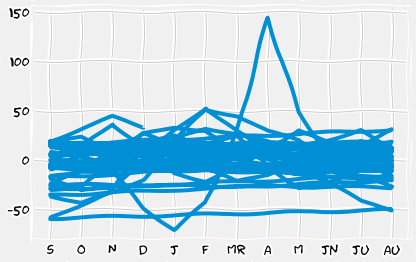

In [27]:
plt.xkcd()
plt.style.use('fivethirtyeight')
plt.plot(df['Month'],df['Returns'])

In [28]:
yr2000 = (df['Date'] >= '2000') & (df['Date'] < '2001')
df2000 = df.loc[yr2000]

In [29]:
yr2001 = (df['Date'] >= '2001') & (df['Date'] < '2002')
df2001 = df.loc[yr2001]

In [30]:
yr2002 = (df['Date'] >= '2002') & (df['Date'] < '2003')
df2002 = df.loc[yr2002]

In [31]:
yr2003 = (df['Date'] >= '2003') & (df['Date'] < '2004')
df2003 = df.loc[yr2003]

In [32]:
yr2004 = (df['Date'] >= '2004') & (df['Date'] < '2005')
df2004=df.loc[yr2004]

In [33]:
yr2005 = (df['Date'] >= '2005') & (df['Date'] < '2006')
df2005 = df.loc[yr2005]

In [34]:
yr2006 = (df['Date'] >= '2006') & (df['Date'] < '2007')
df2006 = df.loc[yr2006]

In [35]:
yr2007 = (df['Date'] >= '2007') & (df['Date'] < '2008')
df2007 = df.loc[yr2007]

In [36]:
yr2008 = (df['Date'] >= '2008') & (df['Date'] < '2009')
df2008 = df.loc[yr2008]

In [37]:
yr2009 = (df['Date'] >= '2009') & (df['Date'] < '2010')
df2009 = df.loc[yr2009]

In [38]:
yr2010 = (df['Date'] >= '2010') & (df['Date'] < '2011')
df2010 = df.loc[yr2010]

In [39]:
yr2011 = (df['Date'] >= '2011') & (df['Date'] < '2012')
df2011 = df.loc[yr2011]

In [40]:
yr2012 = (df['Date'] >= '2012') & (df['Date'] < '2013')
df2012 = df.loc[yr2012]

In [41]:
yr2013 = (df['Date'] >= '2013') & (df['Date'] < '2014')
df2013 = df.loc[yr2013]

In [42]:
yr2014 = (df['Date'] >= '2014') & (df['Date'] < '2015')
df2014 = df.loc[yr2014]

In [43]:
yr2015 = (df['Date'] >= '2015') & (df['Date'] < '2016')
df2015 = df.loc[yr2015]

In [44]:
yr2016 = (df['Date'] >= '2016') & (df['Date'] < '2017')
df2016 = df.loc[yr2016]

In [45]:
yr2017 = (df['Date'] >= '2017') & (df['Date'] < '2018')
df2017 = df.loc[yr2017]

In [46]:
yr2018 = (df['Date'] >= '2018') & (df['Date'] < '2019')
df2018 = df.loc[yr2018]

In [47]:
yr2019 = (df['Date'] >= '2019') & (df['Date'] < '2020')
df2019 = df.loc[yr2019]

In [48]:
yr2020 = (df['Date'] >= '2020') & (df['Date'] < '2021')
df2020 = df.loc[yr2020]

In [49]:
yearly_dataframes = [df2000,df2001,df2002,df2003,df2004,df2005,df2006,df2007,df2008,df2009,df2010,
                     df2011,df2012,df2013,df2014,df2015,df2016,df2017,df2018,df2019,df2020]

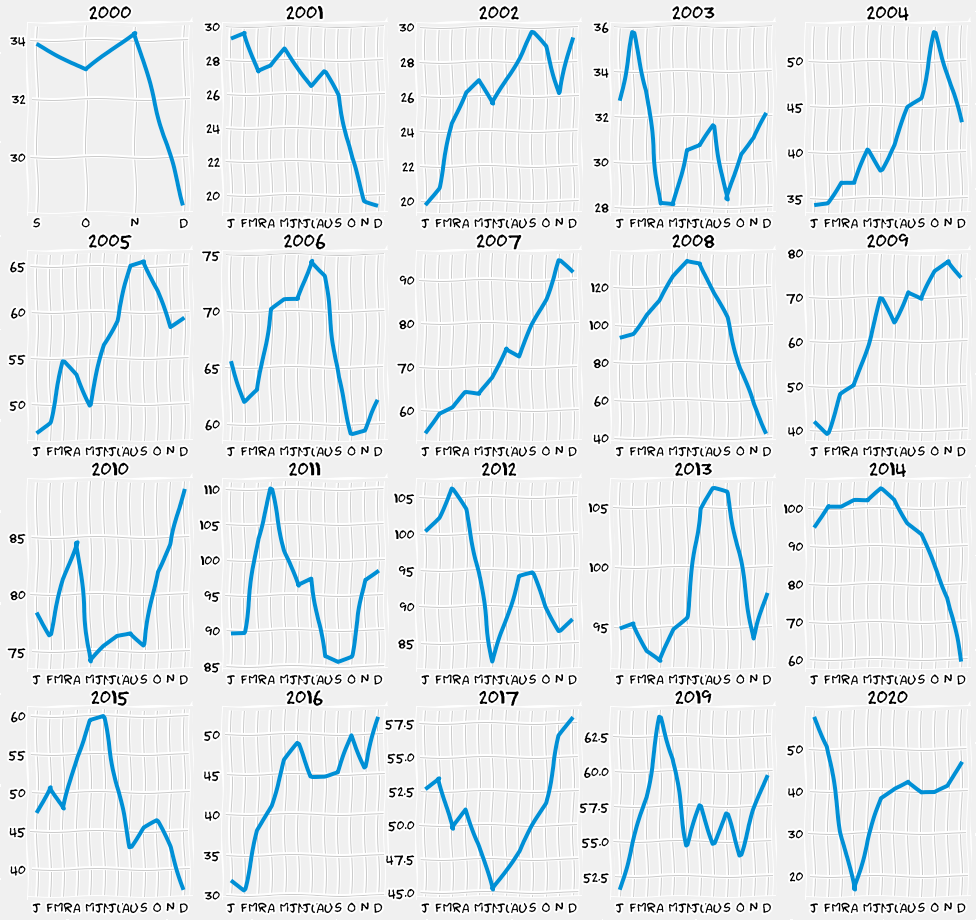

In [50]:
plt.style.use('fivethirtyeight')

figure, axis = plt.subplots(4,5, figsize=(15,15))
  
axis[0, 0].plot(df2000['Month'],df2000['Close'])
axis[0, 0].set_title("2000")
  
axis[0, 1].plot(df2001['Month'],df2001['Close'])
axis[0, 1].set_title("2001")
  
axis[0,2].plot(df2002['Month'],df2002['Close'])
axis[0,2].set_title("2002")
  
axis[0, 3].plot(df2003['Month'],df2003['Close'])
axis[0,3].set_title("2003")

axis[0,4].plot(df2004['Month'],df2004['Close'])
axis[0,4].set_title("2004")
  
axis[1,0].plot(df2005['Month'],df2005['Close'])
axis[1,0].set_title("2005")
  
axis[1,1].plot(df2006['Month'],df2006['Close'])
axis[1,1].set_title("2006")
  
axis[1,2].plot(df2007['Month'],df2007['Close'])
axis[1,2].set_title("2007")

axis[1,3].plot(df2008['Month'],df2008['Close'])
axis[1,3].set_title("2008")

axis[1,4].plot(df2009['Month'],df2009['Close'])
axis[1,4].set_title("2009")
  
axis[2,0].plot(df2010['Month'],df2010['Close'])
axis[2,0].set_title("2010")
  
axis[2,1].plot(df2011['Month'],df2011['Close'])
axis[2,1].set_title("2011")
  
axis[2,2].plot(df2012['Month'],df2012['Close'])
axis[2,2].set_title("2012")

axis[2,3].plot(df2013['Month'],df2013['Close'])
axis[2,3].set_title("2013")
  
axis[2,4].plot(df2014['Month'],df2014['Close'])
axis[2,4].set_title("2014")
  
axis[3,0].plot(df2015['Month'],df2015['Close'])
axis[3,0].set_title("2015")
  
axis[3,1].plot(df2016['Month'],df2016['Close'])
axis[3,1].set_title("2016")

axis[3,2].plot(df2017['Month'],df2017['Close'])
axis[3,2].set_title("2017")

axis[3,3].plot(df2019['Month'],df2019['Close'])
axis[3,3].set_title("2019")

axis[3,4].plot(df2020['Month'],df2020['Close'])
axis[3,4].set_title("2020")

plt.show() 

Inferences from Close vs months 
1. Closing prices are high during later half of the year ie: June onwards they rise and retain that form till the end of the year except for the years 2010,2011,2012 where we witness a reverse trend.
2. The reason for prices to be high during this time could probably account the summer vacations in the northern hemisphere and festivities in the asian sub-continent.
3. Aftermath of 2008 global recession could be one of the reasons for prices to display a reverse trend. 

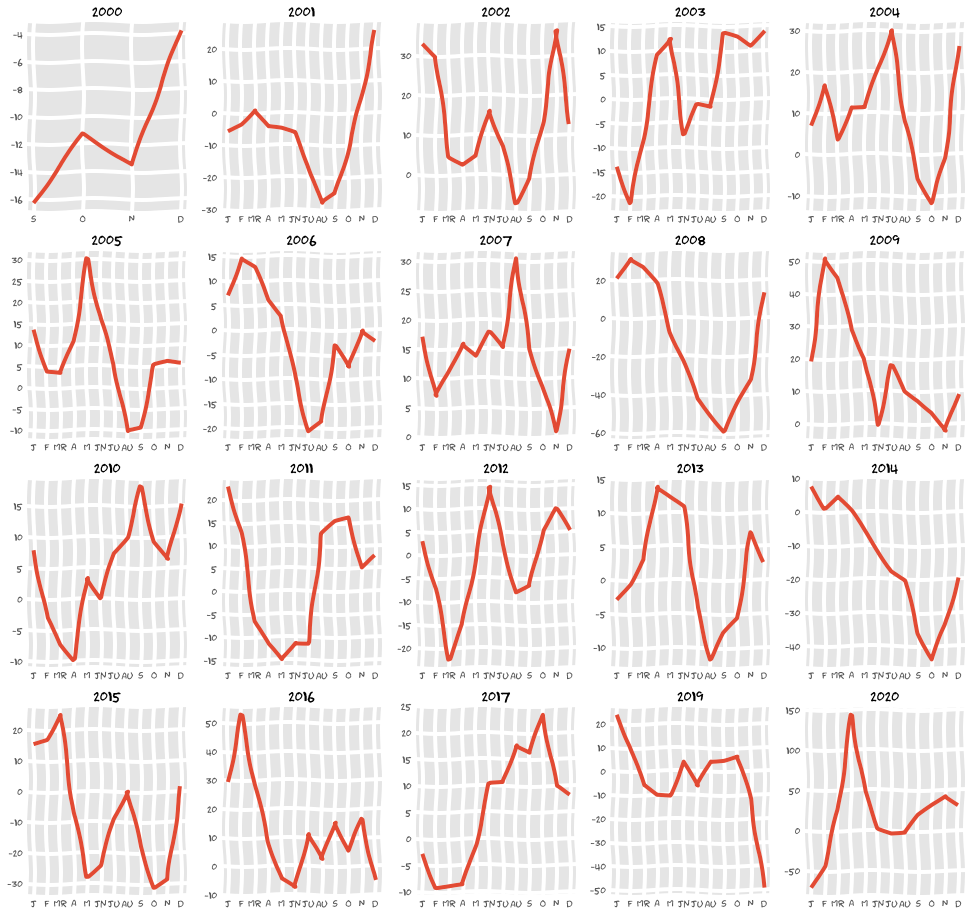

In [51]:
plt.style.use('ggplot')

figure, axis = plt.subplots(4,5, figsize=(15,15))
  
axis[0, 0].plot(df2000['Month'],df2000['Returns'])
axis[0, 0].set_title("2000")
  
axis[0, 1].plot(df2001['Month'],df2001['Returns'])
axis[0, 1].set_title("2001")
  
axis[0,2].plot(df2002['Month'],df2002['Returns'])
axis[0,2].set_title("2002")
  
axis[0, 3].plot(df2003['Month'],df2003['Returns'])
axis[0,3].set_title("2003")

axis[0,4].plot(df2004['Month'],df2004['Returns'])
axis[0,4].set_title("2004")
  
axis[1,0].plot(df2005['Month'],df2005['Returns'])
axis[1,0].set_title("2005")
  
axis[1,1].plot(df2006['Month'],df2006['Returns'])
axis[1,1].set_title("2006")
  
axis[1,2].plot(df2007['Month'],df2007['Returns'])
axis[1,2].set_title("2007")

axis[1,3].plot(df2008['Month'],df2008['Returns'])
axis[1,3].set_title("2008")

axis[1,4].plot(df2009['Month'],df2009['Returns'])
axis[1,4].set_title("2009")
  
axis[2,0].plot(df2010['Month'],df2010['Returns'])
axis[2,0].set_title("2010")
  
axis[2,1].plot(df2011['Month'],df2011['Returns'])
axis[2,1].set_title("2011")
  
axis[2,2].plot(df2012['Month'],df2012['Returns'])
axis[2,2].set_title("2012")

axis[2,3].plot(df2013['Month'],df2013['Returns'])
axis[2,3].set_title("2013")
  
axis[2,4].plot(df2014['Month'],df2014['Returns'])
axis[2,4].set_title("2014")
  
axis[3,0].plot(df2015['Month'],df2015['Returns'])
axis[3,0].set_title("2015")
  
axis[3,1].plot(df2016['Month'],df2016['Returns'])
axis[3,1].set_title("2016")

axis[3,2].plot(df2017['Month'],df2017['Returns'])
axis[3,2].set_title("2017")

axis[3,3].plot(df2019['Month'],df2019['Returns'])
axis[3,3].set_title("2019")

axis[3,4].plot(df2020['Month'],df2020['Returns'])
axis[3,4].set_title("2020")

plt.show() 

Inferences from Returns every month:
1. Min and Max percentage both in returns column have been observed in the year 2020 for obvious reasons that prices slumped to negative values hitting -70% returns and took a while to attain the standard band which shoots up the % of returns to nearly 150% 
2. Generally we have a much appreciative scale towards the end of the year with 20-30% returns. This has a co-relation with prices starting to climb from the latter half of the years and attaining handsome returns by the end.

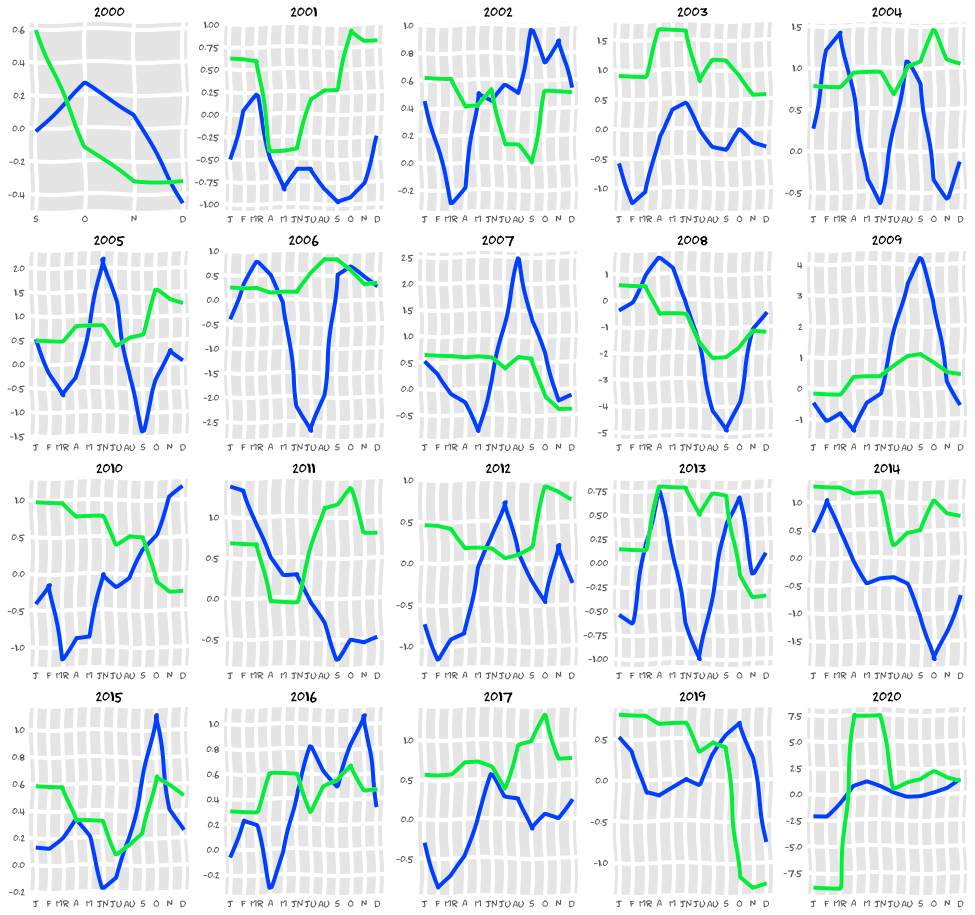

In [52]:
plt.style.use('seaborn-bright')

figure, axis = plt.subplots(4,5, figsize=(15,15))
  
axis[0, 0].plot(df2000['Month'],df2000['inf_change'])
axis[0, 0].plot(df2000['Month'],df2000['% gdp_change'])
axis[0, 0].set_title("2000")
  
axis[0, 1].plot(df2001['Month'],df2001['inf_change'])
axis[0, 1].plot(df2001['Month'],df2001['% gdp_change'])
axis[0, 1].set_title("2001")
  
axis[0,2].plot(df2002['Month'],df2002['inf_change'])
axis[0,2].plot(df2002['Month'],df2002['% gdp_change'])
axis[0,2].set_title("2002")
  
axis[0, 3].plot(df2003['Month'],df2003['inf_change'])
axis[0, 3].plot(df2003['Month'],df2003['% gdp_change'])
axis[0,3].set_title("2003")

axis[0,4].plot(df2004['Month'],df2004['inf_change'])
axis[0,4].plot(df2004['Month'],df2004['% gdp_change'])
axis[0,4].set_title("2004")
  
axis[1,0].plot(df2005['Month'],df2005['inf_change'])
axis[1,0].plot(df2005['Month'],df2005['% gdp_change'])
axis[1,0].set_title("2005")
  
axis[1,1].plot(df2006['Month'],df2006['inf_change'])
axis[1,1].plot(df2006['Month'],df2006['% gdp_change'])
axis[1,1].set_title("2006")
  
axis[1,2].plot(df2007['Month'],df2007['inf_change'])
axis[1,2].plot(df2007['Month'],df2007['% gdp_change'])
axis[1,2].set_title("2007")

axis[1,3].plot(df2008['Month'],df2008['inf_change'])
axis[1,3].plot(df2008['Month'],df2008['% gdp_change'])
axis[1,3].set_title("2008")

axis[1,4].plot(df2009['Month'],df2009['inf_change'])
axis[1,4].plot(df2009['Month'],df2009['% gdp_change'])
axis[1,4].set_title("2009")
  
axis[2,0].plot(df2010['Month'],df2010['inf_change'])
axis[2,0].plot(df2010['Month'],df2010['% gdp_change'])
axis[2,0].set_title("2010")
  
axis[2,1].plot(df2011['Month'],df2011['inf_change'])
axis[2,1].plot(df2011['Month'],df2011['% gdp_change'])
axis[2,1].set_title("2011")
  
axis[2,2].plot(df2012['Month'],df2012['inf_change'])
axis[2,2].plot(df2012['Month'],df2012['% gdp_change'])
axis[2,2].set_title("2012")

axis[2,3].plot(df2013['Month'],df2013['inf_change'])
axis[2,3].plot(df2013['Month'],df2013['% gdp_change'])
axis[2,3].set_title("2013")
  
axis[2,4].plot(df2014['Month'],df2014['inf_change'])
axis[2,4].plot(df2014['Month'],df2014['% gdp_change'])
axis[2,4].set_title("2014")
  
axis[3,0].plot(df2015['Month'],df2015['inf_change'])
axis[3,0].plot(df2015['Month'],df2015['% gdp_change'])
axis[3,0].set_title("2015")
  
axis[3,1].plot(df2016['Month'],df2016['inf_change'])
axis[3,1].plot(df2016['Month'],df2016['% gdp_change'])
axis[3,1].set_title("2016")

axis[3,2].plot(df2017['Month'],df2017['inf_change'])
axis[3,2].plot(df2017['Month'],df2017['% gdp_change'])
axis[3,2].set_title("2017")

axis[3,3].plot(df2019['Month'],df2019['inf_change'])
axis[3,3].plot(df2019['Month'],df2019['% gdp_change'])
axis[3,3].set_title("2019")

axis[3,4].plot(df2020['Month'],df2020['inf_change'])
axis[3,4].plot(df2020['Month'],df2020['% gdp_change'])
axis[3,4].set_title("2020")

plt.show() 

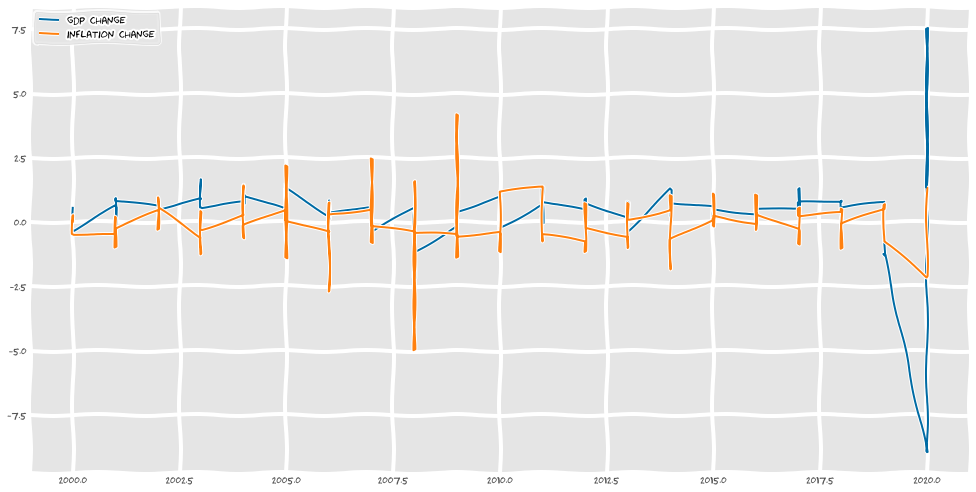

In [53]:
plt.figure(figsize=(15,8))
plt.style.use('tableau-colorblind10')
plt.plot(df['year'],df['% gdp_change'],linewidth=2,label='gdp change' )
plt.plot(df['year'],df['inf_change'],linewidth=2,label='inflation change')
plt.legend()
plt.show()

**Inferences from the graph**
1. Blue line signifies inflation change.
2. Green line signifies % gdp change
3. Getting back to basics we know gdp and inflation are inversely related. If gdp goes up inflation will go down and vice-versa. This is evident in every years plot on top there.
4. If we retrospect into the column we realise that %gdp column indicates 3month ahead gdp change from that date with value being reflected on that day itself. In short this column will show us how gdp has behaved ahead and help us understand if the economy would bloom ahead or shrink.Same goes for inflation.
5. There is one exception here, in 2008 though the gdp had shrinked considerably inflation remained pretty low.
6. Q1 on an average is at better values from other quarters reason being that is the start of financial year with policies being announced..

In [54]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


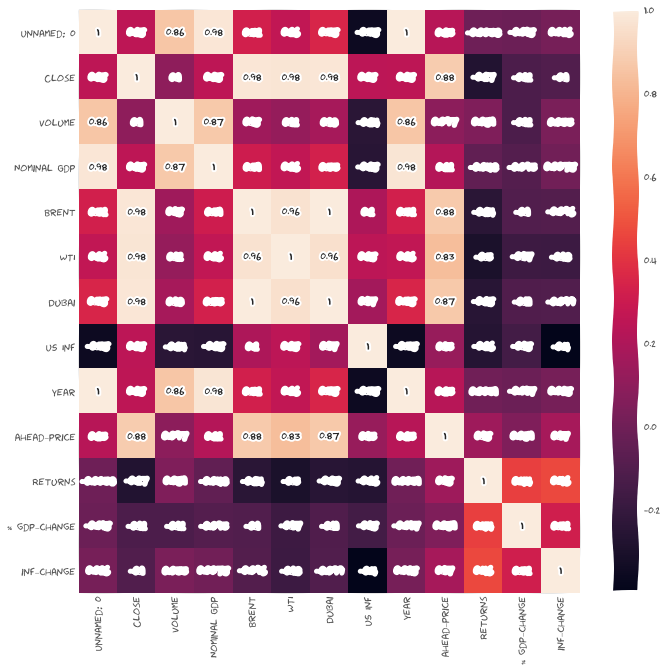

In [55]:
plt.figure(figsize = (10,10))
plt.style.use('ggplot')
corr = df.corr()
sns.heatmap(corr,annot=True)


1. Features like Close, Brent,WTI,Dubai have extremely high corelation with ahead price.
2. Returns,gdp change and inflation change have very low co-relation
3. But we would be using gdp change and inflation change in our independent features 
4. target feature would be our returns column 

## **Model Building**



Below is our Training dataset. Here we would be leaving the last 6 rows that is last 6 months of training dataset.

training dataset duration: [Sep 2000 - Sep 2020]
Test Dataset : [Jan 2021 - Mar2021] But values in this dataset would be from the last quater of 2020 (ie: Oct 2020 - Dec 2020) and we would make predictions for test data based on these values.

In [56]:
model1_df = df.copy()

In [57]:
model1_df = model1_df.set_index('Date')

In [58]:
model1_df.drop(['Unnamed: 0','Nominal Gdp','US Inf','Month','year'], axis=1, inplace=True)

In [59]:
model1_df.tail()

,Close,Volume,Brent,WTI,Dubai,ahead_price,Returns,% gdp_change,inf_change
Date,,,,,,,,,
2020-08-31,42.388095,6720832.0,44.257143,40.71,43.705238,41.126316,-2.977,1.115,-0.186
2020-09-30,39.625714,7025110.0,41.085455,42.34,41.103182,47.012857,18.642,1.337,-0.110
2020-10-31,39.554545,7685767.0,40.470000,39.63,39.704091,52.102106,31.722,2.097,0.175
2020-11-30,41.126316,6910303.0,43.224286,39.40,42.577619,59.061053,43.609,1.534,0.537
2020-12-31,47.012857,6490838.0,49.854348,40.94,49.316522,62.357391,32.639,1.312,1.337


In [60]:
train = model1_df[:'2020-09-30']
valid = model1_df['2020-10-31':]

In [61]:
x_train = train.drop(['ahead_price','Returns'],axis=1)
y_train = train['Returns']
x_valid = valid.drop(['ahead_price','Returns'],axis=1)
y_valid = valid['Returns']

In [62]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression

In [63]:
scaler = RobustScaler()

In [64]:
x_train = scaler.fit_transform(x_train)
x_valid = scaler.fit_transform(x_valid)


In [65]:
linreg = LinearRegression()
linreg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
y_pred = linreg.predict(x_valid)

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('R2 score: {} '.format(r2_score(y_valid,y_pred)))
print('mean sq error: {}'. format(mean_squared_error(y_valid,y_pred)))
print('root mean sq error: {}'.format(np.sqrt(mean_squared_error(y_valid,y_pred))))

R2 score: -38.5983550141432 
mean sq error: 1154.875279633825
root mean sq error: 33.98345596954237


In [68]:
linreg.score(x_train,y_train)

0.36740290015998467

In [69]:
linreg.score(x_valid,y_valid)

-38.5983550141432

 **Model Optimization**

In [70]:
lasoreg = Lasso(alpha=3, max_iter=10000, tol = 0.01)
lasoreg.fit(x_train,y_train) 

Lasso(alpha=3, copy_X=True, fit_intercept=True, max_iter=10000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.01, warm_start=False)

In [71]:
lasoreg.score(x_train,y_train)

0.282758144852411

In [72]:
lasoreg.score(x_valid,y_valid)

-34.140542628687115

In [73]:
y_pred_laso = lasoreg.predict(x_valid)

In [74]:
print('Mean Sq Error: {}'. format(mean_squared_error(y_valid,y_pred_laso)))
print('Root Mean Sq Error: {}'.format(np.sqrt(mean_squared_error(y_valid,y_pred_laso))))

Mean Sq Error: 1024.864390965092
Root Mean Sq Error: 32.01350325979792


In [75]:
ridgereg = Ridge(alpha=400,max_iter=1000, tol=0.001)
ridgereg.fit(x_train,y_train)

Ridge(alpha=400, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [76]:
y_pred_ridge = ridgereg.predict(x_valid)

In [77]:
ridgereg.score(x_train,y_train)

0.28929084749083656

In [78]:
ridgereg.score(x_valid,y_valid)

-36.62004366998163

In [79]:
print('Ridge mean sq error: {}'. format(mean_squared_error(y_valid,y_pred_ridge)))
print('Ridge root mean sq error: {}'.format(np.sqrt(mean_squared_error(y_valid,y_pred_ridge))))

Ridge mean sq error: 1097.1783660631638
Ridge root mean sq error: 33.12368285778567


In [80]:
results = pd.concat([pd.Series(y_pred),pd.Series(y_pred_laso),pd.Series(y_pred_ridge)],axis=1)

In [81]:
results.columns = ['linear','Laso','Ridge']

In [82]:
results['Actual'] = valid['Returns']['2020-10-31':'2020-12-31']

In [83]:
results.index = ['2020-10-31','2020-11-30','2020-12-31']

In [84]:
results['Actual'] = valid['Returns']

In [85]:
results

,linear,Laso,Ridge,Actual
2020-10-31,16.114692,3.630552,6.907088,31.722
2020-11-30,0.901148,2.953209,3.388262,43.609
2020-12-31,-4.738495,7.488049,0.111359,32.639


## **Model 2**

In [86]:
model2_df = df.copy()


In [87]:
model2_df = model2_df.set_index('Date')

In [88]:
model2_df.drop(['Unnamed: 0','Nominal Gdp','US Inf','Month','year'], axis=1, inplace=True)

In [89]:
model2_df.tail()

,Close,Volume,Brent,WTI,Dubai,ahead_price,Returns,% gdp_change,inf_change
Date,,,,,,,,,
2020-08-31,42.388095,6720832.0,44.257143,40.71,43.705238,41.126316,-2.977,1.115,-0.186
2020-09-30,39.625714,7025110.0,41.085455,42.34,41.103182,47.012857,18.642,1.337,-0.110
2020-10-31,39.554545,7685767.0,40.470000,39.63,39.704091,52.102106,31.722,2.097,0.175
2020-11-30,41.126316,6910303.0,43.224286,39.40,42.577619,59.061053,43.609,1.534,0.537
2020-12-31,47.012857,6490838.0,49.854348,40.94,49.316522,62.357391,32.639,1.312,1.337


In [90]:
train2 = model2_df['2000-09-30':'2020-09-30']
valid2 = model2_df['2020-10-31':]

In [91]:
x_train2 = train2.drop(['ahead_price','Returns'],axis=1)
y_train2 = train2['ahead_price']
x_valid2 = valid2.drop(['ahead_price','Returns'],axis=1)
y_valid2 = valid2['ahead_price']

In [92]:
x_train2 = scaler.fit_transform(x_train2)
x_valid2 = scaler.fit_transform(x_valid2)

In [93]:
linreg1 = LinearRegression()
linreg1.fit(x_train2,y_train2) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [94]:
y_pred1 = linreg1.predict(x_valid2)

In [95]:
linreg1.score(x_train2,y_train2)

0.8634831510075063

In [96]:
linreg1.score(x_valid2,y_valid2)

-57.256311038224176

In [97]:
print('R2 score: {} '.format(r2_score(y_valid2,y_pred1)))
print('mean sq error: {}'. format(mean_squared_error(y_valid2,y_pred1)))
print('root mean sq error: {}'.format(np.sqrt(mean_squared_error(y_valid2,y_pred1))))

R2 score: -57.256311038224176 
mean sq error: 1064.5607685406098
root mean sq error: 32.62760745964389


In [98]:
lassoreg1 = Lasso(alpha=15,max_iter=100000,tol=0.1)
lassoreg1.fit(x_train2,y_train2)

Lasso(alpha=15, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.1, warm_start=False)

In [99]:
y_pred_lasso1 = lassoreg1.predict(x_valid2)

In [100]:
lassoreg1.score(x_train2,y_train2)

0.15545659544726365

In [101]:
lassoreg1.score(x_valid2,y_valid2)

-0.5892418176794303

In [102]:
print('mean sq error: {}'. format(mean_squared_error(y_valid2,y_pred_lasso1)))
print('root mean sq error: {}'.format(np.sqrt(mean_squared_error(y_valid2,y_pred_lasso1))))

mean sq error: 29.041394154113306
root mean sq error: 5.389006787350829


In [103]:
ridge1_reg = Ridge(alpha=365,max_iter=10000,tol=0.001)
ridge1_reg.fit(x_train2,y_train2)

Ridge(alpha=365, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [104]:
y_pred_ridge1 = ridge1_reg.predict(x_valid2)

In [105]:
ridge1_reg.score(x_train2,y_train2)

0.6578174367411491

In [106]:
ridge1_reg.score(x_valid2,y_valid2)

-14.273877771872499

In [107]:
print('mean sq error: {}'. format(mean_squared_error(y_valid2,y_pred_ridge1)))
print('root mean sq error: {}'.format(np.sqrt(mean_squared_error(y_valid2,y_pred_ridge1))))

mean sq error: 279.110894075513
root mean sq error: 16.70661228602355


In [108]:
result2 = pd.concat([pd.Series(y_pred1),pd.Series(y_pred_lasso1),pd.Series(y_pred_ridge1)],axis=1)

In [109]:
result2.columns = ['linear','Lasso','Ridge']

In [110]:
result2.index = valid2.index

In [111]:
result2['Actual'] = valid2['ahead_price']

In [112]:
result2

,linear,Lasso,Ridge,Actual
Date,,,,
2020-10-31,42.875215,59.988496,53.041721,52.102106
2020-11-30,61.412600,61.891040,59.563884,59.061053
2020-12-31,118.062122,66.470809,91.274462,62.357391


Model 1: Predicting 3 month ahead returns
Model 2: Predicting 3 Month ahead prices

1. Regularisation techniques seem to have worked better with prices.
2. we can try other techniques as well like log transformation or feature transformation to optimize the performance of our model.

## **ARIMA Model**

In [113]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 4.8 MB/s 
     |████████████████████████████████| 9.5 MB 30.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [114]:
from pmdarima.arima import  auto_arima

In [115]:
arima_df = df.copy()

In [116]:
arima_df.drop(['Unnamed: 0','Volume','Nominal Gdp','Brent','WTI','Dubai','US Inf','Month','year','Close',
                          '% gdp_change','inf_change'],axis=1,inplace=True)

In [117]:
arima_df = arima_df.set_index('Date')

In [118]:
train = arima_df['2000-09-30':'2020-09-30']
valid = arima_df['2020-10-31':]

In [119]:
train_feature = train['Returns']
valid_feature = valid['Returns']

In [120]:
model_arima = auto_arima(train_feature)
model_arima.fit(train_feature)

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [121]:
forecast = model_arima.predict(n_periods=3)

In [122]:
forecast = pd.DataFrame(forecast, index=valid.index, columns=['Predictions'])

In [123]:
forecast

,Predictions
Date,
2020-10-31,-0.901383
2020-11-30,-5.857521
2020-12-31,-2.642184


In [124]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [125]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Returns'])-np.array(forecast['Predictions'])),2)))
rms

39.8161766888015

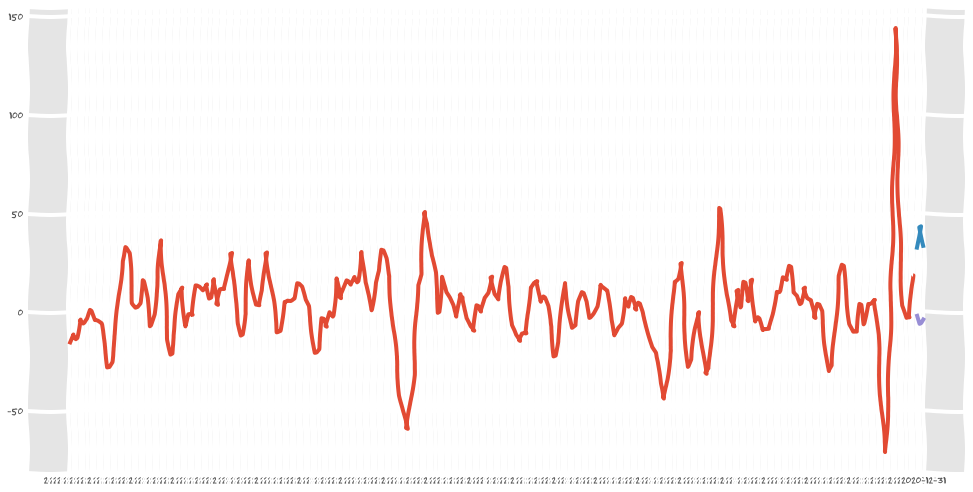

In [126]:
plt.figure(figsize=(15,8))
plt.plot(train['Returns'])
plt.plot(valid['Returns'])
plt.plot(forecast['Predictions'])

Purple line is the forecast prediction

## **Model 4: Decision Tree**

In [127]:
dc_df = df.copy()

In [128]:
dc_df.drop(['Unnamed: 0','WTI','Nominal Gdp','US Inf','Month','year'],axis=1,inplace=True)

In [129]:
dc_df = dc_df.set_index('Date')

In [130]:
train_dc = dc_df[:'2020-09-30	']
valid_dc = dc_df['2020-10-31':]

In [131]:
x_train = train_dc.drop('Returns',axis=1)
y_train = train_dc['Returns']
x_valid = valid_dc.drop('Returns',axis=1)
y_valid = valid_dc['Returns']

In [132]:
x_train = scaler.fit_transform(x_train)
x_valid = scaler.fit_transform(x_valid)

In [133]:
from sklearn.tree import DecisionTreeRegressor

In [134]:
dc_reg = DecisionTreeRegressor(criterion='mae',max_features=4,max_depth=3,max_leaf_nodes=3)
dc_reg.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=4, max_leaf_nodes=3,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [135]:
y_pred_dc = dc_reg.predict(x_valid)

In [136]:
dc_reg.score(x_train,y_train)

0.2052049966095043

In [137]:
dc_reg.score(x_valid,y_valid)

-44.490776918594385

In [138]:
print('mean sq error: {}'.format(mean_squared_error(y_valid,y_pred_dc)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_valid,y_pred_dc))))

mean sq error: 1326.7261656666667
rmse: 36.42425243799338


In [211]:
from sklearn.ensemble import AdaBoostRegressor
ada_reg = AdaBoostRegressor(learning_rate=0.45,n_estimators=10)
ada_reg.fit(x_train,y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=0.45, loss='linear',
                  n_estimators=10, random_state=None)

In [212]:
y_pred_ada = ada_reg.predict(x_valid)

In [213]:
print('mean sq error: {} '.format(mean_squared_error(y_valid,y_pred_ada)))
print('rmse:{}'.format(np.sqrt(mean_squared_error(y_valid,y_pred_ada))))

mean sq error: 1051.7268955252994 
rmse:32.43033912134283
